In [1]:
# Import Packages
import pandas as pd # Matrix Operations
import numpy as np # Linear Algebra
import os # OS Functions

# GRAPHING
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.patches as mpatches
import seaborn as sns
# %matplotlib inline

# MACHINE LEARNING
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering, OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import manifold


# NATURAL LANGUAGE PROCCESSING (NLP)
import gensim
import gensim.downloader as api
from gensim.models import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# MISC
import distinctipy # Generate n colors
import re # Regex
import random # Random Operations
import string
from itertools import chain
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy

#Color class for formatting outputs
class COLOR:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def make_table(array, dropna = False, dec = 3):
    df = pd.value_counts(array, dropna=dropna).to_frame().reset_index()
    df['pct'] = round(df['count'] / sum(df['count']), dec)
    return(df)

def clean_data(data):
    """Cleaning Data for analysis
    ARGS:
        data: data to clean
    RETURNS:
        none
    """
    # Filtering Data to ensure they accepeted the survey and they are eligible
    data = data[(data['s_eligible'] == "1") & (data['s_intro'] == "1")]
    # Drop columns: 's_eligible', 's_intro' and 4 other columns (That are all NRB Related)
    data = data.drop(columns=['s_eligible', 's_intro', 's_nrb', 's_nrb_residence', 's_nrb_us', 's_nrb_overnight', 's_datayear'])
    # Converting #NULL!'s/None's to "NaN" datatype
    data = data.replace({'#NULL!':np.nan, None:np.nan})
    data = data.apply(pd.to_numeric, errors='ignore')
    return data

def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens
    ARGS:
        text: text to tokenize.
    RETURNS:
        tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

def vectorize(list_of_docs, model, api_model = False):
    """Generate vectors for list of documents using a Word Embedding
    ARGS:
        list_of_docs: list of documents
        model: gensim's word embedding
    RETURNS:
        list of document vectors
    """
    features = [] # List of Features

    for tokens in list_of_docs: # For each set of tokens in the list of docs
        zero_vector = np.zeros(model.vector_size) # Initialize vector
        vectors = [] # List of Vectors
        for token in tokens: # For each token in sentance
            if api_model:
                if token in model: # Only add tokens that are known to the wv model to the vector list
                    try:
                        vectors.append(model[token])
                    except KeyError:
                        continue
            else:
                if token in model.wv: # Only add tokens that are known to the wv model to the vector list
                    try:
                        vectors.append(model.wv[token])
                    except KeyError:
                        continue
        if vectors: # If the List is not empty
            vectors = np.asarray(vectors) # Convert to Array
            avg_vec = vectors.mean(axis=0) # Calculate Mean
            features.append(avg_vec) # Add to Features
        else:
            features.append(zero_vector) # Otherwise add empty vector to Features
    return features

def set_all_seeds(seed = 42, echo = True):
    """Set all seeds
    ARGS: 
        seed: seed to set for repoducibility
        echo: print console logs
    RETURNS:
        none
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    if echo:
        print(COLOR.GREEN, "Seeds have been set to: ", COLOR.BOLD, seed, COLOR.END, sep='')

def get_text_cols(data):
    """Get columns with text answers
    ARGS:
        data: dataframe with columns
    RETURNS:
        list of column names
    """
    return([x for x in data if x.startswith('o')]) #Columns that start with 'o'

class NLP():
    """Cluster Class
        Class to hold related models and information regarding text analysis
    """
    def __init__(self, data, model = None, echo = True, reset_seeds=True):
        """INIT

        ARGS:
            data: data to clusterize
            num_clusters: number of clusters to use (if applicable)
            algorithm: algorithm to use
            echo: print console logs

        RETURNS:
            none
        """

        # Storing Variables into class
        self.data = data

        # Booleans to keep track of what operations have been done for helper functions
        self.tokenized = False
        self.dim_reduced = False
        self.clustered = False

        if reset_seeds:
            set_all_seeds(echo=echo)
            
        # Cleaning Data
        temp_frame = pd.DataFrame(np.array(data.copy()), columns=['variable']) # Convert column to array, drop NaN's
        temp_frame = temp_frame[~temp_frame['variable'].isnull()]
        self.indexi = temp_frame.index
        print(len(temp_frame), 'total samples')
        #TEMPORARY
        custom_stopwords = set(stopwords.words("english")) # Declare stop words
        temp_frame['tokens'] = temp_frame['variable'].map(lambda x: clean_text(x, word_tokenize, custom_stopwords)) # Remove stopwords/uneeded characters
        self.docs = temp_frame['variable'].values # English type values for sentances
        self.tokenized_docs = temp_frame['tokens'].values # Creating tokenized values from english words
        # Creating the Model
        if model == None:
            self.model = Word2Vec(sentences=self.tokenized_docs, vector_size=100, workers=1, seed=seed) # Feeding the tokenized values into the model
            self.vectorized_docs = vectorize(self.tokenized_docs, model=self.model) # Creating vectors for each doc 
        else:
            self.model = model
            self.vectorized_docs = vectorize(self.tokenized_docs, model=self.model, api_model=True)
        if echo:
            print('Successfully Tokenized')
        self.tokenized = True

    def dimension_reduce(self, dim_redu_algorithm = 'pca', echo = True, reset_seeds=True):
        """Reduce Dimensions
        ARGS:
            dim_redu_algorithm: algorithm to use to reduce dimensions to two
            echo: console log boolean
        OUTPUTS:
            nothing
        """
        if not self.tokenized:
            print(COLOR.RED, 'ERROR: No tokens found.', COLOR.END, sep='')
            return
        if reset_seeds:
            set_all_seeds(echo=echo)
        self.dim_redu_algorithm = dim_redu_algorithm # Setting the algorithm
        # Dimensionality Reducution
        if self.dim_redu_algorithm == 'pca': # Principal Component Analysis (PCA)
            self.pca = PCA(n_components=2).fit(self.vectorized_docs)
            self.datapoints = self.pca.transform(self.vectorized_docs)
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'isomap': # Non-Linear - Isometric Mapping (ISOMAP)
            self.iso = manifold.Isomap(n_neighbors=3, n_components=2).fit(self.vectorized_docs)
            self.datapoints = self.iso.transform(self.vectorized_docs)
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'tsne': # T-distributed Stochastic Neighbor Embedding (TSNE)
            self.tsn = manifold.TSNE(n_components=2, perplexity=50)
            self.datapoints = self.tsn.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'mds': # Multidimensional scaling (MDS)
            self.mds = manifold.MDS(n_components=2, max_iter=10, eps=1)
            self.datapoints = self.mds.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'lle':
            self.lle = manifold.LocallyLinearEmbedding(n_neighbors=5, n_components=2)
            self.datapoints = self.lle.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'spectral_emb':
            self.lle = manifold.SpectralEmbedding(n_components=2)
            self.datapoints = self.lle.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        else:
            print(COLOR.RED, COLOR.BOLD, 'ERROR: ', self.dim_redu_algorithm, 'is not an available algorithm', COLOR.END)
            return
        self.datapoints['sentance'] = self.docs # Add the english sentance to the dataframe
        self.datapoints['orig_index'] = self.indexi
        self.X = self.datapoints[['component1', 'component2']].to_numpy() # Convert X/Y components to self.X
        self.dim_reduced = True
        if echo:
            print(COLOR.DARKCYAN, 'Reduced dimensions to 2 using ', COLOR.BLUE, COLOR.BOLD, self.dim_redu_algorithm.upper(), COLOR.END, sep='')
    
    def clusterize(self, cluster_algorithm = 'kmeans', num_clusters = 15, echo=True, reset_seeds=True):
        """Apply Clusters to data
        ARGS:
            cluster_algorithm: algorithm to use to cluterize data
            num_clusters: number of clusters to use (if applicable)
            echo: console log boolean
        OUTPUTS:
            nothing
        """
        if not self.dim_reduced:
            print(COLOR.RED, 'ERROR: Dimensions have not been reduced.', COLOR.END, sep='')
            return
        if reset_seeds:
            set_all_seeds(echo=echo)
        self.num_clusters = num_clusters # Setting number of clusters
        self.cluster_algorithm = cluster_algorithm # Setting cluster algorithm
        # KMEANS
        if (self.cluster_algorithm == 'kmeans'):
            self.km = KMeans(n_clusters=self.num_clusters).fit(self.X)
            self.ca = self.km
            self.datapoints['cluster'] = self.km.labels_
        # MINIBATCH_KMEANS
        if (self.cluster_algorithm == 'kmeans_mb'):
            self.km = MiniBatchKMeans(n_clusters=self.num_clusters, batch_size=500, n_init='auto').fit(self.X)
            self.ca = self.km
            self.datapoints['cluster'] = self.km.labels_
        # DBSCAN
        if (self.cluster_algorithm == 'dbscan'):
            self.db = DBSCAN(eps=0.01, min_samples=20).fit(self.X)
            self.ca = self.db
            self.num_clusters = len(set(self.db.labels_)) - (1 if -1 in self.db.labels_ else 0) # Number of clusters (not including -1, i.e samples that do not fit in a cluster)
            self.datapoints['cluster'] = self.db.labels_
        # SPECTRAL CLUSTERING
        if (self.cluster_algorithm == 'spectral_clustering'):
            self.sc = SpectralClustering(n_clusters=self.num_clusters).fit(self.X)
            self.ca = self.sc
            self.datapoints['cluster'] = self.sc.labels_
        # OPTICS
        if (self.cluster_algorithm == 'optics'):
            self.op = OPTICS(min_samples=5).fit(self.X)
            self.ca = self.op
            self.datapoints['cluster'] = self.op.labels_
        self.clustered = True
        if echo:
            print(COLOR.DARKCYAN, 'Clustered using ', COLOR.BLUE, COLOR.BOLD, self.cluster_algorithm.upper(), COLOR.END, sep='')
            print(COLOR.YELLOW, "For n_clusters = ", str(self.num_clusters), COLOR.END, sep='')
            print(COLOR.YELLOW, COLOR.BOLD, f"Silhouette coefficient: {silhouette_score(self.X, self.ca.labels_):0.2f}", COLOR.END, sep='')
            try:
                print(COLOR.YELLOW, COLOR.BOLD, f"Inertia: {self.ca.inertia_:0.3f}", COLOR.END, sep='')
            except:
                pass
    def get_sil_values(self):
        """Get Silhouette Values
        ARGS:
            None
        RETUNRS:
            prints silhouette values
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        sample_silhouette_values = silhouette_samples(self.X, self.ca.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(self.num_clusters):
            cluster_silhouette_values = sample_silhouette_values[self.ca.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )

    def get_cluster_labels(self):
        """Get Cluster Labels
        ARGS:
            None
        RETURNS:
            array of the cluster labels
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        return(np.unique(self.datapoints['cluster']))

    def get_cluster(self, cluster):
        """Get Cluster Information
        ARGS:
            cluster: number of cluster to return
        RETURNS:
            dataframe with a given cluster's information/sentances
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        return(self.datapoints[self.datapoints['cluster'] == cluster])

    def get_clusters(self, cluster_filter = None):
        """Get Clusters
        ARGS:
            None
        RETURNS:
            dataframe with sentances sorted into a column for each cluster
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        # Filter by Cluster
        if cluster_filter is None:
            cluster_filter = self.get_cluster_labels()

        df = pd.DataFrame()
        for clust in self.get_cluster_labels():
            # print(self.get_cluster(clust)['sentance'].to_numpy())
            if clust in cluster_filter:
                df = pd.concat([df, pd.DataFrame(self.get_cluster(clust)['sentance'].to_numpy(), columns=['cluster_' + str(clust)])], axis=1)
        return(df)

    def viz_clusters(self, cluster_filter = None, figsize = (10, 10), num_annotations = 100, max_char_length = 20, hide_labels=False, hide_legend=False, reset_seeds=True, echo=True):
        """Visualize Clusters
        ARGS:
            figisze: size for figure
            num_annotations: number of ramdom annotations to display on figure
            max_char_length: maximum character length for sentances to be displayed
            hide_labels: boolean to hide labels
            hide_legend: boolean to hide legend
        RETURNS:
            figure of clusters
        """
        # Declaring Figsize
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        if reset_seeds:
            set_all_seeds(echo=echo)
        plt.figure(figsize=figsize, dpi=100)

        # Declaring Colors based on Clusters
        color_list = distinctipy.get_colors(self.num_clusters)
        # self.datapoints['colorCode'] = [color_list[x] for x in self.datapoints['cluster']]
        self.datapoints['colorCode'] = [(0,0,0) if x == -1 else color_list[x] for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes unused points the Black cluster)
        self.datapoints['alpha'] = [0.05 if x == -1 else 0.3 for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes Black points more transparent)
        chart_data = self.datapoints.copy()
        
        # Filter by Cluster
        if cluster_filter is not None:
            chart_data = chart_data[chart_data['cluster'].isin(cluster_filter)]
        else:
            cluster_filter = self.get_cluster_labels()

        # Plot datapoints with associated colors/alphas
        plt.scatter(chart_data['component1'], chart_data['component2'], s=50, color=chart_data['colorCode'], alpha=chart_data['alpha'], edgecolors='none')
        # Setting X/Y Labels
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")

        if ~hide_legend:
            patchList = []
            for i, color in enumerate(color_list):
                if i in cluster_filter:
                    data_key = mpatches.Patch(color=color, label='Cluster ' + str(i))
                    patchList.append(data_key)
            plt.legend(handles=patchList, title='Cluster')
        
        # Display rabdom labels
        if ~hide_labels:
            num_annotated = 0
            while (True):
                # Ensures we only annotate x amount of labels
                if (num_annotated == num_annotations):
                    break
                # Grab Random Point
                sent_num = np.random.randint(0, len(chart_data))
                # Ensuring Sentance is less than specified length for readability
                if (len(chart_data.iloc[sent_num]['sentance']) <= max_char_length):
                    plt.annotate(chart_data.iloc[sent_num]['sentance'], (chart_data.iloc[sent_num]['component1'], chart_data.iloc[sent_num]['component2']), size = 7, weight='bold')
                    num_annotated += 1
        # Set Plot Title and Display
        plt.title('dim_redu_alg: ' + self.dim_redu_algorithm.upper() + ' clust_alg: ' + self.cluster_algorithm.upper() + ' ' + str(self.num_clusters) + ' clusters')
        plt.show()

KeyboardInterrupt: 

# Importing Data

In [2]:
# Import Data
data = pd.read_parquet(r"C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\nationalData.parquet")
print('Before Filter: ', data.shape)
# data.head()

data_clean = clean_data(data.copy())
print('Post Filter: ', data_clean.shape)
data_clean.head()

Before Filter:  (28082, 346)
Post Filter:  (19977, 339)


,n_IQualtricsID,s_QualtricsLang,o_eligible,s_residence,n_loczip,s_us_int,s_country_int,n_zip_int,s_primary,s_purpose,...,m_act_climb,o_act_climb,m_accom_lodge,n_nightslodge,c_nightslodge,s_npssite,s_sitetype,s_sitesize,s_region,weight_peak
0,R_5ZzD8xdz24Bx17j,EN,NaN,3.0,NaN,1.0,NaN,76107.0,1.0,NaN,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
1,R_fvd9VW1Y8umSWOW,EN,NaN,3.0,NaN,1.0,NaN,78130.0,1.0,NaN,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
2,R_2Nnte2VxZyBU1Er,EN,NaN,3.0,NaN,1.0,NaN,76643.0,1.0,NaN,...,NaN,NaN,0.0,NaN,NaN,1,1,1,5,0.03
3,R_efmlxcfYDsQNzoJ,EN,NaN,3.0,NaN,1.0,NaN,99349.0,2.0,3.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
4,R_6pb7kqH2oedoEzZ,EN,NaN,3.0,NaN,1.0,NaN,41035.0,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,1,1,1,5,0.03


## Available Text Columns

In [3]:
get_text_cols(data_clean)

['o_eligible',
 'o_comm',
 'o_commstay1',
 'o_commstay2',
 'o_entermode',
 'o_enterwater',
 'o_zipflag',
 'o_zipflag2',
 'o_info_osite',
 'o_info_other',
 'o_infoneed',
 'o_mode_other',
 'o_mode_otherwater',
 'o_type',
 'o_fee',
 'o_parks',
 'o_act_nonmotor',
 'o_act_motor',
 'o_act_waterplay',
 'o_act_other1',
 'o_act_other2',
 'o_act_other3',
 'o_motiv_other',
 'o_prog_other',
 'o_history',
 'o_subjects',
 'o_tech_other',
 'o_itech_other',
 'o_disability',
 'o_like1',
 'o_like2',
 'o_like3',
 'o_least1',
 'o_least2',
 'o_least3',
 'o_expect1',
 'o_expect2',
 'o_qual_other',
 'o_sig',
 'o_gender',
 'o_race',
 'o_langother',
 'o_addl',
 'o_act_climb']

In [4]:
# MODEL TO USE FOR NLP
modelGN300 = api.load('word2vec-google-news-300')
# api.info()

# O_LIKE1

### MDS Model

In [8]:
mds_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
mds_model.dimension_reduce('mds')

Seeds have been set to: 42
4990 total samples
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using MDS


Seeds have been set to: 42


Clustered using SPECTRAL_CLUSTERING
For n_clusters = 10
Silhouette coefficient: 0.20
Seeds have been set to: 42


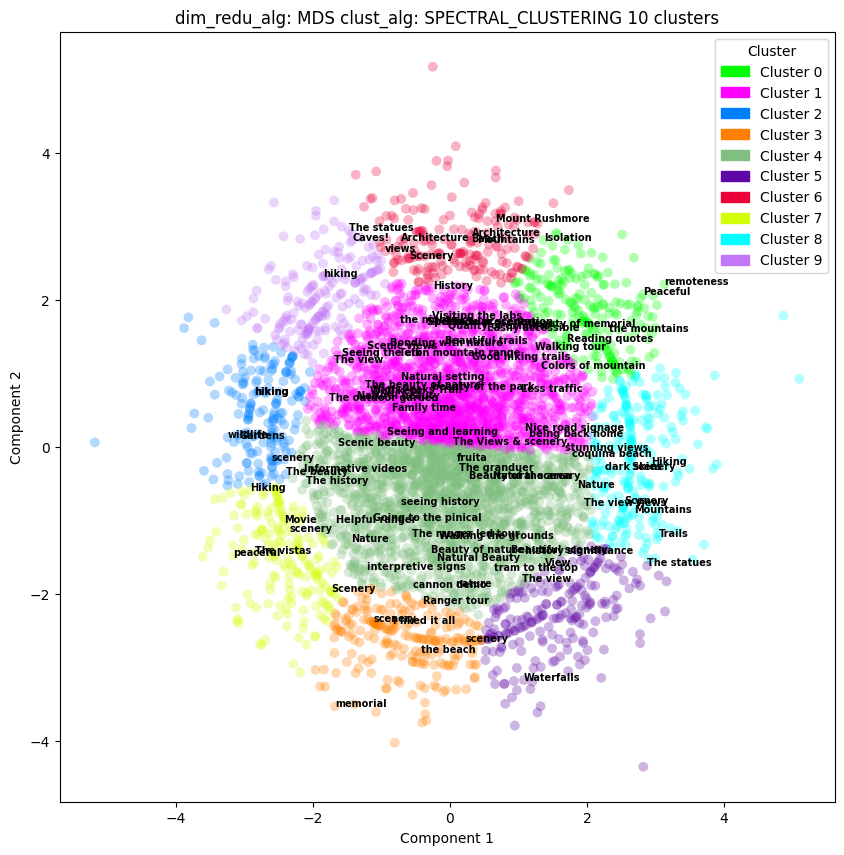

In [9]:
mds_model.clusterize('spectral_clustering', num_clusters=10)
mds_model.viz_clusters()
# mds_model.viz_clusters(cluster_filter=[])

### LLE Model

In [9]:
lle_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
lle_model.dimension_reduce('lle')

Seeds have been set to: 42
Reduced dimensions to 2 using LLE


Clustered using KMEANS
For n_clusters = 10
Silhouette coefficient: 0.81
Inertia: 0.071


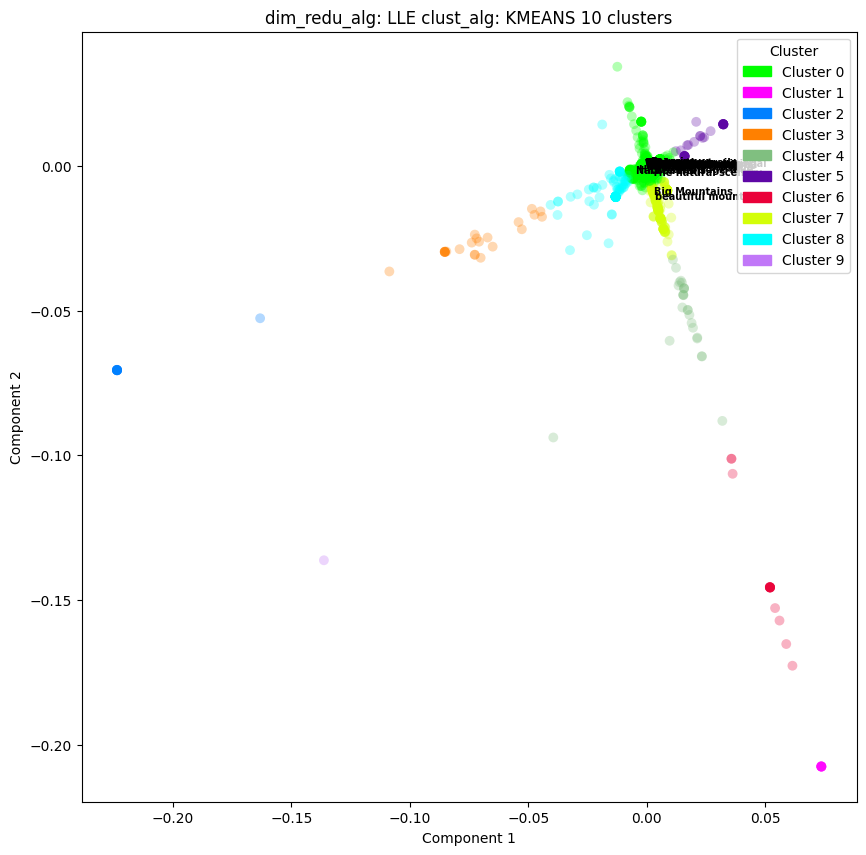

In [10]:
lle_model.clusterize('kmeans', num_clusters=10)
lle_model.viz_clusters()

### SPECT_EMB Model

In [11]:
spect_emb_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
spect_emb_model.dimension_reduce('spectral_emb')

Seeds have been set to: 42
Reduced dimensions to 2 using SPECTRAL_EMB


Clustered using KMEANS
For n_clusters = 10
Silhouette coefficient: 0.55
Inertia: 0.000


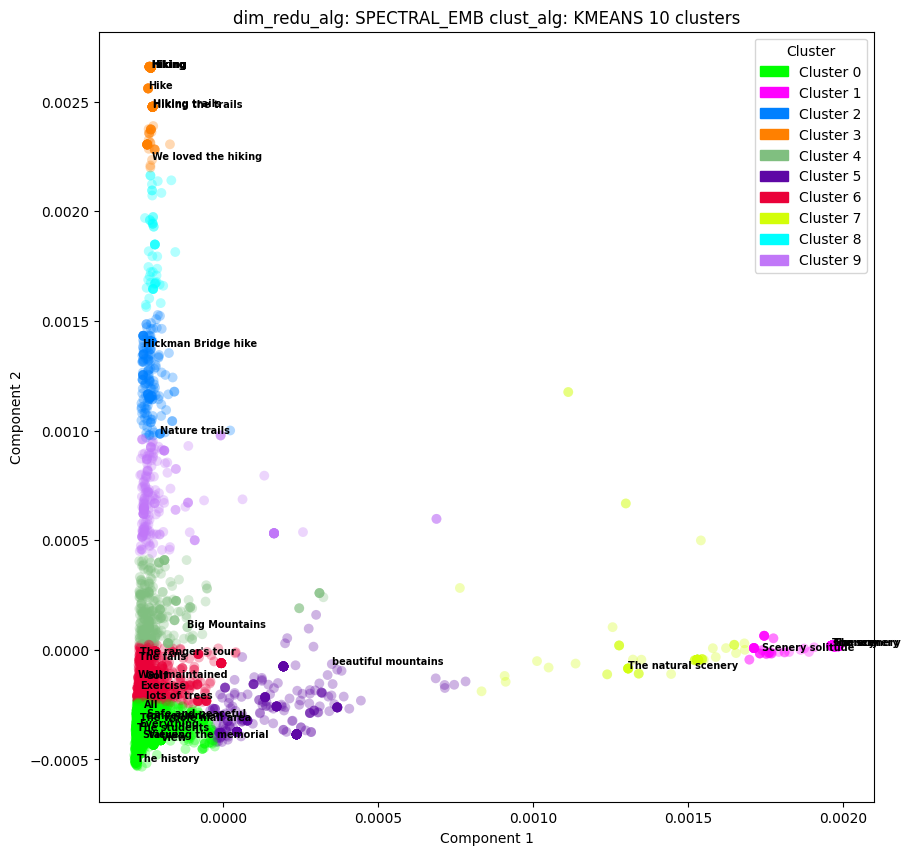

In [12]:
spect_emb_model.clusterize('kmeans', num_clusters=10)
spect_emb_model.viz_clusters()

### PCA Model

In [6]:
pca_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
pca_model.dimension_reduce('pca')

Seeds have been set to: 42
4990 total samples
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using PCA


Seeds have been set to: 42
Clustered using KMEANS
For n_clusters = 15
Silhouette coefficient: 0.43
Inertia: 139.264
Seeds have been set to: 42


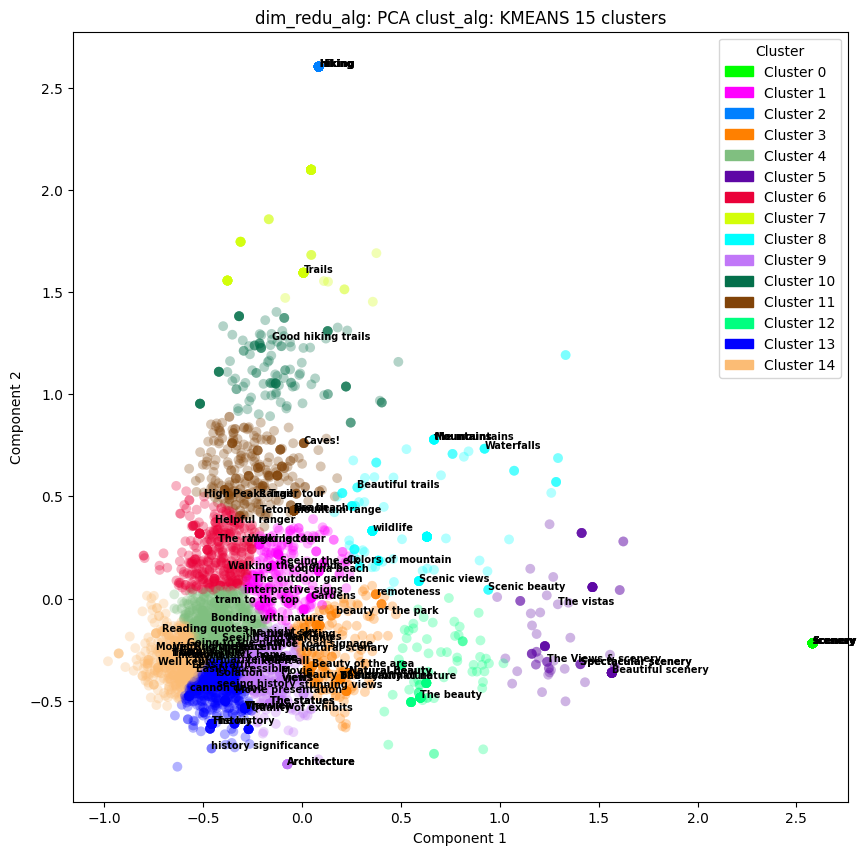

Seeds have been set to: 42


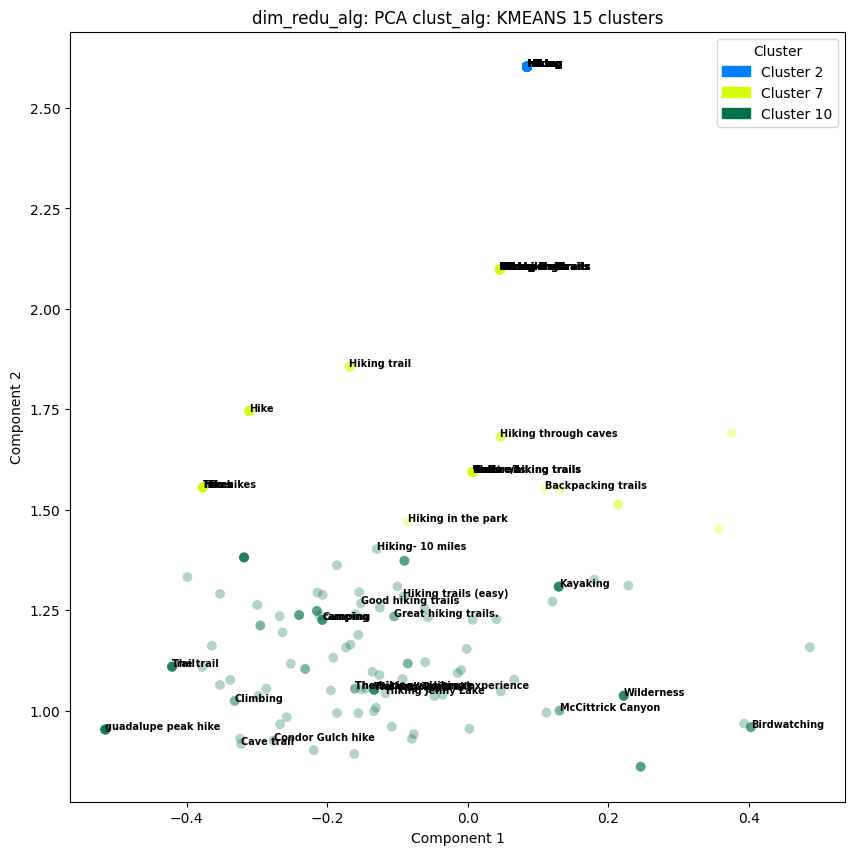

In [7]:
pca_model.clusterize('kmeans', num_clusters=15)
pca_model.viz_clusters(cluster_filter=None)
pca_model.viz_clusters(cluster_filter=[2, 7, 10])

### TSNE Model

In [33]:
tsne_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
tsne_model.dimension_reduce('tsne')

Seeds have been set to: 42
4990 total samples
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using TSNE


Seeds have been set to: 42


Clustered using KMEANS
For n_clusters = 15
Silhouette coefficient: 0.42
Inertia: 601297.625
Seeds have been set to: 42


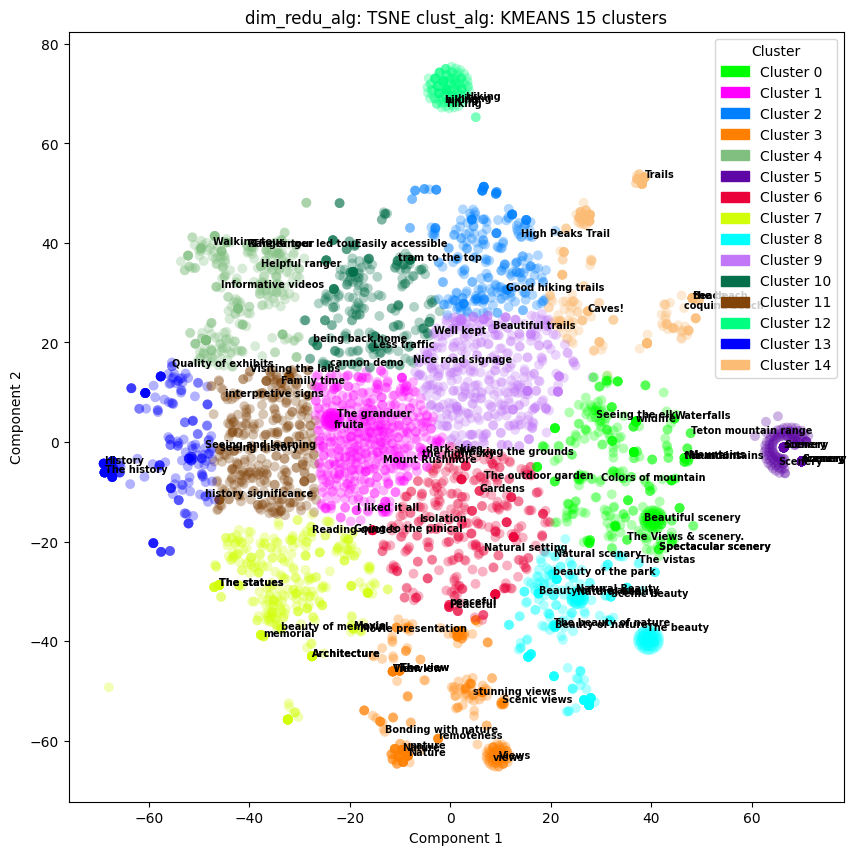

In [34]:
tsne_model.clusterize('kmeans', num_clusters=15)
tsne_model.viz_clusters(num_annotations=100)

In [36]:
tsne_model.get_clusters([13])

[13]


,cluster_13
0,History of settlement
1,Learning about ancient reef/geology
2,Learning about the history of the area
3,History
4,History
...,...
247,History
248,History
249,historical exhibits
250,History


### ISOMAP Model

In [29]:
isomap_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
isomap_model.dimension_reduce('isomap')

Seeds have been set to: 42
4990 total samples
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using ISOMAP


Seeds have been set to: 42
Clustered using KMEANS
For n_clusters = 15


Silhouette coefficient: 0.41
Inertia: 3810.519
Seeds have been set to: 42


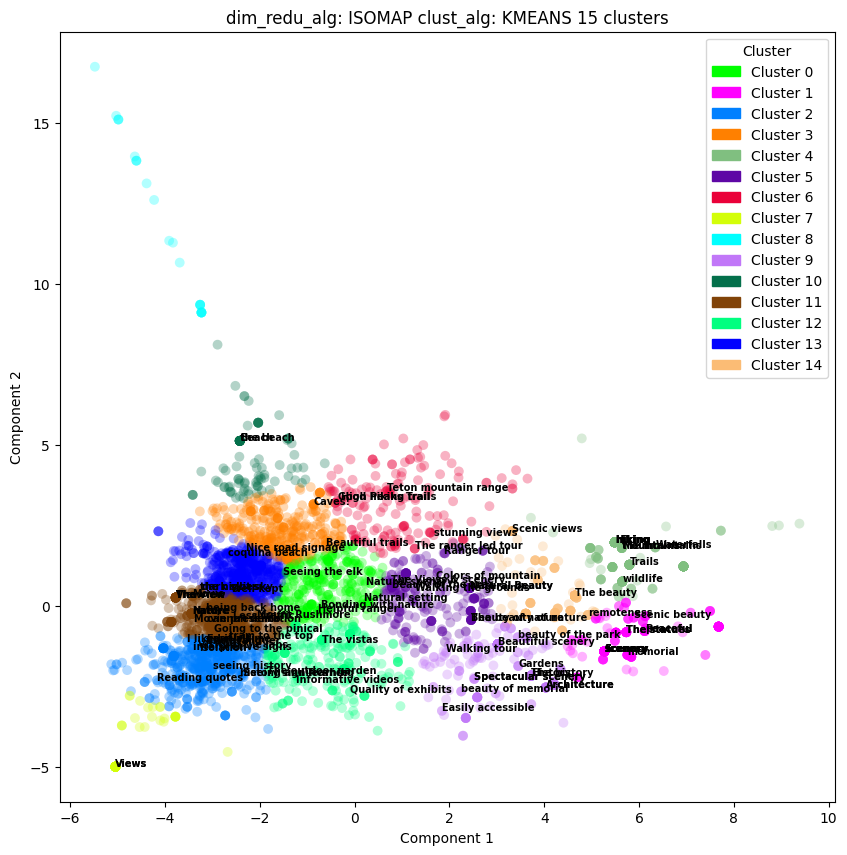

In [30]:
isomap_model.clusterize('kmeans', num_clusters=15)
isomap_model.viz_clusters(num_annotations=100)

In [32]:
df = isomap_model.get_clusters([8, 10])
df.head()

[8, 10]


,cluster_8,cluster_10
0,kayaking,Pratt cabin area and ranger talk
1,kayaking,Frijole Ranch
2,Fishing,frijole ranch
3,Kayaking,Frijole ranch
4,fishing,"Smith Trail hike, recommendation from ranger"


# ANALYSIS

In [38]:
# Import Data
data = pd.read_parquet(r"C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\nationalData.parquet")
print('Before Filter: ', data.shape)
# data.head()

data_clean = clean_data(data.copy())
print('Post Filter: ', data_clean.shape)
data_clean.head()

Before Filter:  (28082, 346)
Post Filter:  (19977, 339)


,n_IQualtricsID,s_QualtricsLang,o_eligible,s_residence,n_loczip,s_us_int,s_country_int,n_zip_int,s_primary,s_purpose,...,m_act_climb,o_act_climb,m_accom_lodge,n_nightslodge,c_nightslodge,s_npssite,s_sitetype,s_sitesize,s_region,weight_peak
0,R_5ZzD8xdz24Bx17j,EN,NaN,3.0,NaN,1.0,NaN,76107.0,1.0,NaN,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
1,R_fvd9VW1Y8umSWOW,EN,NaN,3.0,NaN,1.0,NaN,78130.0,1.0,NaN,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
2,R_2Nnte2VxZyBU1Er,EN,NaN,3.0,NaN,1.0,NaN,76643.0,1.0,NaN,...,NaN,NaN,0.0,NaN,NaN,1,1,1,5,0.03
3,R_efmlxcfYDsQNzoJ,EN,NaN,3.0,NaN,1.0,NaN,99349.0,2.0,3.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
4,R_6pb7kqH2oedoEzZ,EN,NaN,3.0,NaN,1.0,NaN,41035.0,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,1,1,1,5,0.03


In [101]:
tsne_model = NLP(data_clean['o_like1'].iloc[:], model=modelGN300)
tsne_model.dimension_reduce('tsne')

Seeds have been set to: 42
4990 total samples
['Hiking Guadalupe Peak trail' 'great bathrooms' 'Views' ...
 'Quiet- look at fauna/sound of birds/squirrels' 'Scenery' 'Scenery']
Successfully Tokenized
Seeds have been set to: 42
Reduced dimensions to 2 using TSNE


Seeds have been set to: 42


Clustered using KMEANS
For n_clusters = 15
Silhouette coefficient: 0.42
Inertia: 601297.625
Seeds have been set to: 42


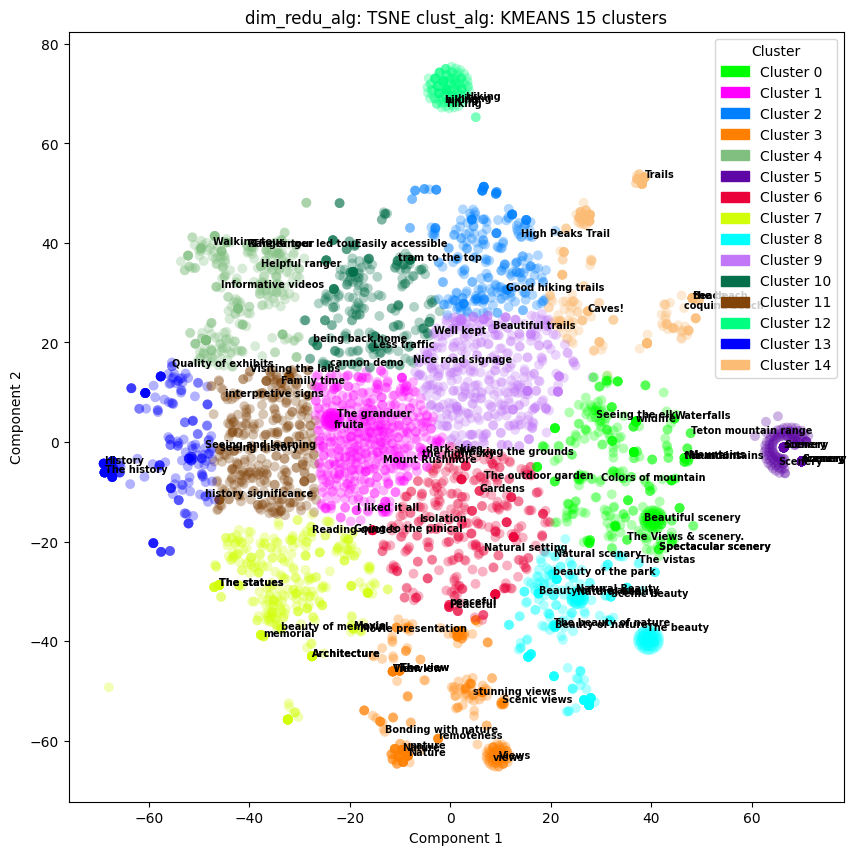

In [102]:
tsne_model.clusterize('kmeans', num_clusters=15)
tsne_model.viz_clusters(num_annotations=100)

In [105]:
hist_data = tsne_model.get_cluster(13)
hist_data.head()

,component1,component2,sentance,orig_index,cluster,colorCode,alpha
11,-59.214882,-4.430597,History of settlement,22,13,"(0.0, 0.0, 1.0)",0.3
120,-52.241901,-4.877774,Learning about ancient reef/geology,277,13,"(0.0, 0.0, 1.0)",0.3
153,-49.449627,-3.294265,Learning about the history of the area,340,13,"(0.0, 0.0, 1.0)",0.3
154,-67.003319,-5.438207,History,341,13,"(0.0, 0.0, 1.0)",0.3
188,-67.003319,-5.438207,History,419,13,"(0.0, 0.0, 1.0)",0.3


In [125]:
df = data_clean.filter(hist_data.orig_index, axis=0)
df.head()

,n_IQualtricsID,s_QualtricsLang,o_eligible,s_residence,n_loczip,s_us_int,s_country_int,n_zip_int,s_primary,s_purpose,...,m_act_climb,o_act_climb,m_accom_lodge,n_nightslodge,c_nightslodge,s_npssite,s_sitetype,s_sitesize,s_region,weight_peak
22,R_dFElLrsTA9Lxxfg,EN,NaN,3.0,NaN,1.0,NaN,7722.0,2.0,2.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
277,R_oqVs0cQ2e0VT1i3,EN,NaN,3.0,NaN,1.0,NaN,66208.0,2.0,3.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
340,R_oxZ153oAnax1Pet,EN,NaN,3.0,NaN,1.0,NaN,80013.0,2.0,2.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
341,R_ayD85CSM9EggzQR,EN,NaN,3.0,NaN,1.0,NaN,45002.0,2.0,1.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03
419,R_mdgnnmpBgyLpwNv,EN,NaN,3.0,NaN,1.0,NaN,70535.0,2.0,2.0,...,0.0,NaN,0.0,NaN,NaN,1,1,1,5,0.03


In [148]:
make_table(df['s_history'], dropna=True)

,s_history,count,pct
0,1.0,22,0.512
1,2.0,21,0.488
